# Attention Pooling



In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

Generating the Dataset

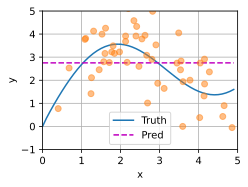

In [4]:
class NonlinearData(d2l.DataModule):
    def __init__(self, n, batch_size):
        self.save_hyperparameters()
        f = lambda x: 2 * torch.sin(x) + x**0.8
        self.x_train, _ = torch.sort(torch.rand(n) * 5)
        self.y_train = f(self.x_train) + torch.randn(n)
        self.x_val = torch.arange(0, 5, 5.0/n)
        self.y_val = f(self.x_val)

    def get_dataloader(self, train):
        arrays = (self.x_train, self.y_train) if train else (self.x_val, self.y_val)
        return self.get_tensorloader(arrays, train)

n = 50
data = NonlinearData(n, batch_size=10)

def plot_kernel_reg(y_hat):
    d2l.plot(data.x_val, [data.y_val, y_hat.detach().numpy()], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(data.x_train, data.y_train, 'o', alpha=0.5);

y_hat = data.y_train.mean().repeat(n)
plot_kernel_reg(y_hat)

Nonparametric Attention Pooling

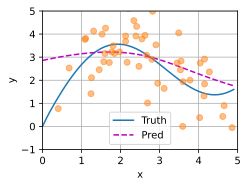

In [5]:
def diff(queries, keys):
    return queries.reshape((-1, 1)) - keys.reshape((1, -1))

def attention_pool(query_key_diffs, values):
    attention_weights = F.softmax(- query_key_diffs**2 / 2, dim=1)
    return torch.matmul(attention_weights, values), attention_weights

y_hat, attention_weights = attention_pool(
    diff(data.x_val, data.x_train), data.y_train)
plot_kernel_reg(y_hat)

Attention weights

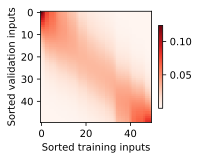

In [6]:
d2l.show_heatmaps([[attention_weights]],
                  xlabel='Sorted training inputs',
                  ylabel='Sorted validation inputs')

Parametric Attention Pooling
given two tensors of shape ($n$, $a$, $b$) and ($n$, $b$, $c$), the shape of their batch matrix multiplication output is ($n$, $a$, $c$)

In [7]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
d2l.check_shape(torch.bmm(X, Y), (2, 1, 6))

Use minibatch matrix multiplication to compute weighted averages of values in a minibatch

In [8]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

Parametric attention pooling

In [9]:
class NWKernelRegression(d2l.Module):
    def __init__(self, keys, values, lr):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.ones(1, requires_grad=True)
    def forward(self, queries):
        y_hat, self.attention_weights = attention_pool(
            diff(queries, self.keys) * self.w, self.values)
        return y_hat

    def loss(self, y_hat, y):
        l = (y_hat.reshape(-1) - y.reshape(-1)) ** 2 / 2
        return l.mean()

    def configure_optimizers(self):
        return d2l.SGD([self.w], self.lr)

Transform the training dataset
to keys and values

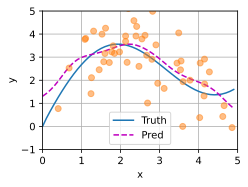

In [11]:
model = NWKernelRegression(data.x_train, data.y_train, lr=1)
model.board.display = False
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

plot_kernel_reg(model.forward(data.x_val))

The region with large attention weights becomes sharper

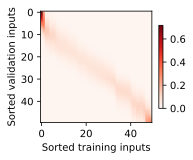

In [12]:
d2l.show_heatmaps([[model.attention_weights]],
                  xlabel='Sorted training inputs',
                  ylabel='Sorted validation inputs')